In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from recbole.data import data_preparation, create_dataset

from logging import getLogger
from recbole.model.general_recommender import BPR, Pop
from recbole.model.sequential_recommender import Caser
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger

import torch
from recbole.data.interaction import Interaction
import os

import make_atomic_files as at

from recbole.config import Config

from recbole.trainer import HyperTuning
from recbole.utils import get_model, get_trainer

In [5]:
def get_history(inter):
    visits = []
    set_uid = set(inter['uid:token'])
    for u in set_uid:
        visits.append(inter[inter['uid:token'] == u]['venue_id:token'].values.tolist())
    
    return np.array(visits)

## Tuning

In [6]:
def tuning():
    def objective_function(config_dict=None, config_file_list=None):
        k = 10

        config_dict = {
            'model': 'BPR',
            'data_path': os.getcwd(),
            'topk': 10,
            'use_gpu': True,
            'gpu_id': '0',
            'seed': 1234

        }

        config = Config(config_dict=config_dict, config_file_list=['foursquare_general.yaml'])
        init_seed(config['seed'], config['reproducibility'])
        dataset = create_dataset(config)
        train_data, valid_data, test_data = data_preparation(config, dataset)
        model_name = config['model']
        model = get_model(model_name)(config, train_data._dataset)
        trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)
        best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)
        test_result = trainer.evaluate(test_data)

        return {
            'model': model_name,
            'best_valid_score': best_valid_score,
            'valid_score_bigger': config['valid_metric_bigger'],
            'best_valid_result': best_valid_result,
            'test_result': test_result
        }

    hp = HyperTuning(objective_function=objective_function, algo='random', early_stop=10,
                    max_evals=100, params_file='bpr.hyper', fixed_config_file_list=['foursquare_general.yaml'])

    hp.run()
    params = hp.best_params
    return params

## Train General Recommendation

In [7]:
def training(params):

    config_dict = {
            'model': 'BPR',
            'data_path': os.getcwd(),
            'topk': 10,
            'use_gpu': True
    }
    # configurations initialization
    k = 10

    config = Config(model='BPR', dataset='foursquare', config_file_list=['foursquare_general.yaml'], config_dict = config_dict | params)

    # init random seed
    init_seed(config['seed'], config['reproducibility'])

    # dataset creating and filtering
    dataset = create_dataset(config)

    # dataset splitting
    train_data, valid_data, test_data = data_preparation(config, dataset)

    model = BPR(config, train_data.dataset).to(config['device'])

    # trainer loading and initialization
    trainer = Trainer(config, model)

    # model training
    best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)

    # model evaluation
    test_result = trainer.evaluate(test_data)
    print(test_result)

    return model, test_result

## Make prediction

In [62]:
# function to choose one item from the recommandation list.
# First, from the visits it extract the relative frequency that a user visited a specific category of POIs.
# Then, if none of the POIs proposed is related to a visited category, it draws at random one item. 
# Otherwise, it normalizes the probability and sample one item from the distribution.
def choose_item(rec_list, category_dict, visits):
    p_v = []
    num_category = len(set(category_dict.values()))

    # transform POI visits in category visits
    visited_category = []
    for i in visits:
        visited_category.append(category_dict[i])

    # get distribution over recommended items
    for i in rec_list:
        category = category_dict[int(i)]
        p = (len(np.where(np.array(visited_category) == int(category))[0]) + 1) / (len(visits) + len(category_dict) + num_category +1)
        #extract the probability associated with each category for that users
        p_v.append(p)

    # extract poi based on the popularity
    p = np.array(p_v)/sum(p_v)
    return int(np.random.choice(rec_list, p = p))

In [50]:
def make_predict(model, interactions, items):
    k = 10

    visits = get_history(interactions)

    unique_users = list(set(interactions['uid:token']))

    #make prediction for users
    input_inter = Interaction({
        'uid': torch.tensor(unique_users),
        'venue_id': torch.tensor(visits)
    })

    with torch.no_grad():
        scores = model.full_sort_predict(input_inter).reshape((len(unique_users), -1))

    #length |items| + 1 because of the padding

    # get the 10 items with highest scores
    rec_list = np.argsort(scores, axis = 1)[:, -k:]

    # select one item in the list
    # id-category for POI dictionary
    id_cat = dict(zip(items['venue_id:token'], items['venue_category_name:token']))

    rec_item = []
    for i in range(len(rec_list)):
        rec_item.append(choose_item(rec_list[i], id_cat, visits[i]))

    return rec_item


## Add new values in the dataset

In [51]:
def update_interactions(users, predictions, interactions):
    current_time = max(interactions['timestamp:token'])+1
    
    new_locations = pd.DataFrame({'uid:token': users, 'venue_id:token':predictions, 'timestamp:token':[current_time]*len(predictions)}, columns=['uid:token', 'venue_id:token', 'timestamp:token'])

    interactions = pd.concat([interactions, new_locations], axis = 0).reset_index(drop = True)
    interactions.sort_values(by=['uid:token', 'timestamp:token'], inplace=True)

    interactions.to_csv('foursquare/foursquare.inter', index=False, sep = '\t')

## Feedback Loop

In [52]:
def shannon_entropy(visits):
    p_e = []
    for poi in visits:
        p_e.append(len(np.where(visits == poi)[0]) / len(visits))
        
    se = - sum(p_e * np.log(p_e))/np.log(len(visits))
    return se

In [63]:
at.og_atomic_files()

hit = []
prec = []
card = []
entropy = []

inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')
items = pd.read_csv('foursquare/foursquare.item', sep='\t')

unique_users = list(set(inter['uid:token']))
unique_locations = list(set(inter['venue_id:token']))

m = 5
params = tuning()

for i in range(30):

    if i % m == 0:
        model, results = training(params)
        # save hit@10 and precision for every trained model
        hit.append(results['hit@10'])
        prec.append(results['precision@10'])

    predictions = make_predict(model, inter, items)
    update_interactions(unique_users, predictions, inter)

    # update interactions
    inter = pd.read_csv('foursquare/foursquare.inter', sep='\t')

    # shannon entropy for each user
    visits = get_history(inter)
    en = np.apply_along_axis(shannon_entropy, 1, visits)
    entropy.append(np.mean(en))

    card.append(len(set(predictions)))

running parameters:                                    
{'dynamic': True, 'embedding_size': 128, 'learning_rate': 0.0024552749590276814, 'mlp_hidden_size': '[64,64,64]', 'sample_num': 1, 'train_batch_size': 4096}
current best valid score: 0.4663                       
current best valid result:                             
OrderedDict([('hit@10', 0.4663), ('precision@10', 0.0466)])
current test result:                                   
OrderedDict([('hit@10', 0.4201), ('precision@10', 0.042)])
running parameters:                                                   
{'dynamic': False, 'embedding_size': 96, 'learning_rate': 0.0543683100877237, 'mlp_hidden_size': '[64,64,64]', 'sample_num': 1, 'train_batch_size': 4096}
running parameters:                                                   
{'dynamic': True, 'embedding_size': 96, 'learning_rate': 0.0005227429964541693, 'mlp_hidden_size': '[128,128]', 'sample_num': 1, 'train_batch_size': 4096}
running parameters:                              

In [56]:
import matplotlib.pyplot as plt

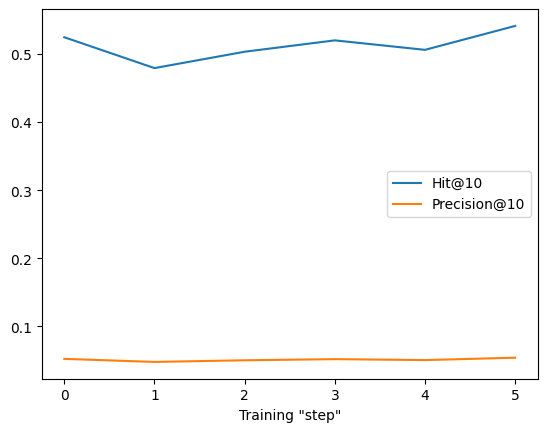

In [64]:
plt.plot(range(len(hit)), hit)
plt.plot(range(len(hit)), prec)
plt.legend(['Hit@10', 'Precision@10'])
plt.xlabel('Training "step"')
plt.show()

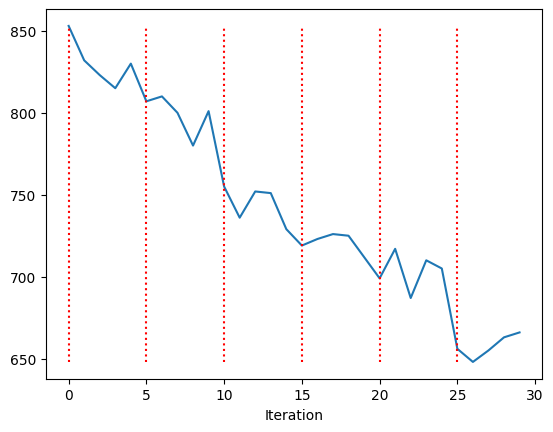

In [65]:
plt.plot(range(len(card)), card)
plt.vlines(range(0,30,5),min(card), max(card), 'red', 'dotted')
plt.xlabel('Iteration')
plt.show()

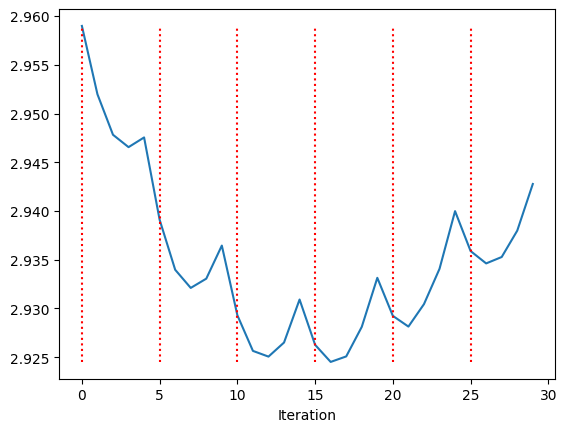

In [66]:
plt.plot(range(len(card)), entropy)
plt.vlines(range(0,30,5),min(entropy), max(entropy), 'red', 'dotted')
plt.xlabel('Iteration')
plt.show()